# ChinaCXRSet

Distribución del dataset:

- 336 casos de pacientes con manifestación de tuberculosis
- 326 casos normales 

Atributos 

- Género
- Edad
- Indica la anormalidad(Sano o Enfermo con Manifestación de Tuberculosis) 

Atributos finales
- Ruta de la imagen `image_name`
- Condición `condition`

Label map:
```python
labels_map = {
    0: "normal",
    1: "tuberculosis",
    2: "neumonia",
    3: "covid-19"
}
```

# Cargar los datos del Dataset
## Inicializar librerias

In [1]:
import os
import random

import numpy as np
import pandas as pd

import sklearn.model_selection #Librería para división del dataset

mapa_condiciones = {
    0: "normal",
    1: "tuberculosis",
    2: "neumonia",
    3: "covid-19"
}

## Código de carga del dataset

In [2]:
direccion_dataset = "/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/" #Poner la dirección del dataset aquí
ruta_clinical_readings= os.path.join(direccion_dataset, "ClinicalReadings/")
ruta_cxr_png = os.path.join(direccion_dataset, "CXR_png/")
extension_cxr = "png"
extension_cr = "txt" #Extension Clinical Reading
lista_elementos_dataset = os.listdir(ruta_clinical_readings)
datos = [] #np.zeros((len(lista_elementos_dataset),), dtype=[("path", np.str_), ("genre", np.str_), ("age", "f4"), ("condition", "a10")])

for idx, elemento in enumerate(lista_elementos_dataset):
    nombre_elemento = elemento.split(".")[0]
    ruta_elemento_cxr = os.path.join(ruta_cxr_png, "{}.{}".format(nombre_elemento, extension_cxr))
    ruta_elemento_cr = os.path.join(ruta_clinical_readings, "{}.{}".format(nombre_elemento, extension_cr))
    nombre_elemento_cxr = "{}.{}".format(nombre_elemento, extension_cxr)
    with open(ruta_elemento_cr, 'r') as archivo_texto:
        datos_archivo_texto = archivo_texto.read() #Obtengo la informacion del dataset
        datos_archivo_texto = datos_archivo_texto.rstrip() #Eliminar tabulación final
        datos_archivo_texto.replace("\t", "")
        atributos_archivo = datos_archivo_texto.split('\n') #Separar por enters
        condicion_paciente = atributos_archivo[-1] #Ultimo elemento
        genero = ""
        edad = 0
        if "," in atributos_archivo[0]:
            genero_edad = atributos_archivo[0].rstrip().lstrip().split(",")
        
        else:
            genero_edad = atributos_archivo[0].rstrip().split(" ")
            #Verificar si el genero y la edad estan unidos
            if len(genero_edad) == 1:
                if genero_edad[0].find('female') == 0:
                    genero_edad.append(genero_edad[0].lstrip("female"))
                    genero_edad[0] = "female"
                elif genero_edad[0].find('male') == 0:
                    genero_edad.append(genero_edad[0].lstrip("male"))
                    genero_edad[0] = "male"
        #Eliminar los caracteres vacios
        genero_edad = [valido for valido in genero_edad if valido]

        genero, edad = genero_edad[0:2]

        if "yrs" in edad: #Convertir a int
            edad = edad.rstrip("yrs")
        elif "yr" in edad: #Convertir a int
            edad = edad.rstrip("yr")
        elif "month" in edad: #Convertir a int
            edad = edad.rstrip("month")
            edad = float(edad)/12.0
        elif "days" in edad: #Convertir a int
            edad = edad.rstrip("days")
            edad = float(edad)/365.0
        
        genero = genero.rstrip().lstrip().lower()
        if genero.find("fem")==0:
            genero = 'female'
        edad = float(edad)
    ruta_elemento_clinical_reading = os.path.join(ruta_clinical_readings)
    datos.append({"image_name":nombre_elemento_cxr, "genre": genero, "age": edad,  "condition": condicion_paciente})
dataset_completo = pd.DataFrame(datos) #Convertir a formato Pandas

## Filtrar los datos

In [3]:
dataset_filtrado = dataset_completo.copy() #Copio el Dataset para no perder los datos, uso copy para hacer un nuevo objeto
########## Operación de filtrar el dataset original ##########
dataset_filtrado.loc[dataset_filtrado["condition"] != "normal", 'condition'] = 'tuberculosis'
dataset_filtrado.loc[dataset_filtrado["condition"] == "normal", 'condition'] = 0
dataset_filtrado.loc[dataset_filtrado["condition"] == "tuberculosis", 'condition'] = 1
########## Operación de eliminar atributos innecesarios para completar el format DIALUNG ##########
dataset_formato_dialung = dataset_filtrado.copy() #Copio el dataset filtrado para no perder los atributos originales
_ = dataset_formato_dialung.pop("age") #Eliminar la columna de la edad 
_ = dataset_formato_dialung.pop("genre") #Eliminar la columna del género
### Impresion de los datos
print("Tamaño del dataset en formato DIALUNG: {}".format(len(dataset_formato_dialung)))
print("Número de columnas: {} Nombre Columnas: {}".format(len(dataset_formato_dialung.columns), list(dataset_formato_dialung.columns)))
conteo_valores = dataset_filtrado["condition"].value_counts()
for condicion in mapa_condiciones.keys(): #Itero sobre las condiciones
    if condicion in conteo_valores.keys():
        print("Número de muestras por condicion {}: {}".format(mapa_condiciones[condicion], conteo_valores[condicion]))
    

Tamaño del dataset en formato DIALUNG: 662
Número de columnas: 2 Nombre Columnas: ['image_name', 'condition']
Número de muestras por condicion normal: 324
Número de muestras por condicion tuberculosis: 338


## Dividir el Dataset

In [4]:
#Primero divido el dataset en train 75% y test 25%, no se puede hacer de golpe para los tres datasets
dataset_train, dataset_test = sklearn.model_selection.train_test_split(dataset_formato_dialung, train_size=0.75, test_size=0.25)
#Divido el dataset de test en 60% y val 40%, al final de la selección será
dataset_test, dataset_val = sklearn.model_selection.train_test_split(dataset_formato_dialung, train_size=0.6, test_size=0.4)

## Crear el la clase Dataset de tipo PyTorch Dataset

In [196]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, io
from torchvision.transforms import Compose


class crearDatasetDIALUNG(Dataset):
    """
    Una clase que hereda los clase torch.utils.data.Dataset para crear un objeto que pueda ser 
    manipulado por la clase DataLoader de PyTorch
    ...

    Atributos
    ----------
    img_labels : pandas.DataFrame
        un objeto de tipo pandas.Dataframe que tiene dos columnas, la primera nombre de la imagen y segunda condicion
    img_dir : str
        Directorio de las imagenes de los datasets
    transform : torchvision.transforms
        Transformaciones de formato PyTorch para aplicar las imagenes
    target_transform : int
        Especifica las transformaciones de la etiqueta y características

    Métodos
    -------
    __len__(self)
        Devuelve el tamaño del dataframe
    """
    def __init__(self, pandas_file, img_dir, transform=None, target_transform=None):
        """
        Parámetros
        ----------
        pandas_file : pandas.DataFrame
            un objeto de tipo pandas.Dataframe que tiene dos columnas, la primera nombre de la imagen y segunda condicion
        img_dir : str
            Directorio de las imagenes de los datasets
        transform : torchvision.transforms
            Transformaciones de formato PyTorch para aplicar las imagenes
        target_transform : int
            Especifica las transformaciones de la etiqueta y características

        """
        self.img_labels = pandas_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """
        Devuelve
        ----------
        int 
            El tamaño del DataFrame en entero
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """Obtiene la imagen del idx del dataset, lee en formato Tensor, aplica las transformaciones
        y devuelve una imagen y su etiqueta.
        Parámetros
        ----------
        idx : int
            índice secuencial de la imagen que se localiza en el DataFrame
        Devuelve
        ----------
        torch.Tensor
            La imagen en formato tensor de PyTorch en Escala de Grises (Tensor[1, alto_imagen, ancho_imagen])
        int 
            La etiqueta correspondiente de la imagen
        """
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) #Busco el nombre de la imagen en la columna cero
        image = read_image(img_path, io.image.ImageReadMode.GRAY) #transformo mi imagen directamente a Escala de grises
        label = self.img_labels.iloc[idx, 1] #Busco el nombre de la etiqueta el DataFrame
        if self.transform: #Aplico transformacion(es) de la imagen
            image = self.transform(image)
        if self.target_transform: #Aplico transformacion(es) a los labels
            label = self.target_transform(label)
        return image, label

In [197]:
from torchvision.transforms import Resize #Cargar herramienta para hacer Rescalado
from torchvision.transforms import Compose #Compose me sirve para apilar varias transformaciones en una sola
from torchvision.transforms import Lambda #Convertir tensor de salida a one-hot-encoded 
import torch 

resize_transform = Resize((1024,1024)) #Cambiar el tamaño a 1024x1024
transformaciones_dataset = Compose([resize_transform]) #Apila las transformaciones
transformacion_salida = Lambda(lambda y: torch.zeros(4, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)) #Hago un

#Creo objetos de tipo crearDatasetDIALUNG
train_datasetDIALUNG = crearDatasetDIALUNG(dataset_train, ruta_cxr_png, transformaciones_dataset, transformacion_salida)
test_datasetDIALUNG = crearDatasetDIALUNG(dataset_test, ruta_cxr_png, transformaciones_dataset, transformacion_salida)
val_datasetDIALUNG = crearDatasetDIALUNG(dataset_val, ruta_cxr_png, transformaciones_dataset, transformacion_salida)

In [198]:
from torch.utils.data import DataLoader #Clase dataloader para cargar en PyTorch los objetos de tipo Dataset

#Creo objetos de tipo DataLoader en lotes de 64 imagenes y barajeados aleatoriamente
train_dataloader = DataLoader(train_datasetDIALUNG, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_datasetDIALUNG, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_datasetDIALUNG, batch_size=64, shuffle=True)

## Verificacion del Dataset de Val
Se verifica el Dataset de validación porque es el más pequeño y demora menos en cargar

Feature batch shape: torch.Size([64, 1, 1024, 1024])
Labels batch shape: torch.Size([64, 4])


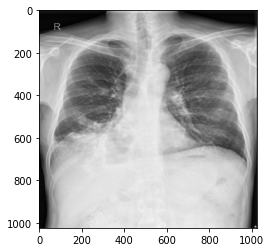

Label one-hot encoding: tensor([0., 1., 0., 0.]) Categoria: tuberculosis


In [199]:
import matplotlib.pyplot as plt
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label one-hot encoding: {label} Categoria: {mapa_condiciones[int(torch.argmax(label))]}")

# Guardar los datos finales
## Funciones para copiar el dataset filtrado a una nueva carpeta
Guardar los datasets originales en la ruta deseada y calcula el tamaño del mismo

In [9]:
import math
import shutil #Utilidad para copiar datos

# Funcion para convertir bytes a su represetanción adecuada
#https://stackoverflow.com/questions/5194057/better-way-to-convert-file-sizes-in-python?noredirect=1&lq=1
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "{} {}".format(s, size_name[i])

def anadir_ruta_al_csv(ruta, nombre_dataset):
    return os.path.join(nombre_dataset, ruta)

#Funcion para copiar el dataset a una nueva carpeta
def copiar_dataset_filtrado(dataset, ruta_dataset, carpeta_salida_dataset, nombre_dataset, copiar = False):
    tamano_dataset = 0
    #checo si la carpeta existe
    nuevo_directorio_dataset = os.path.join(carpeta_salida_dataset, nombre_dataset)
    if os.path.exists(nuevo_directorio_dataset):
        print("El Directorio del nuevo dataset {} existe".format(nuevo_directorio_dataset))
    else:
        print("Directorio creado en: {}".format(dataset_formato_dialung))
        os.mkdir(nuevo_directorio_dataset)

    for idx_img in range(len(dataset)):
        ruta_original_imagen = os.path.join(ruta_dataset, dataset_formato_dialung.iloc[idx_img, 0])
        tamano_dataset += os.path.getsize(ruta_original_imagen)
        if copiar:
            shutil.copy(ruta_original_imagen, nuevo_directorio_dataset)

    print("Tamaño del dataset filtrado: {}".format(convert_size(tamano_dataset))) 

def guardar_csv_datasets(carpeta_salida_dataset, nombre_dataset, dataset_original_filtrado, dialung_train, dialung_test, dialung_val):
    nombre_salida_csv = "csv_datasets"
    nuevo_directorio_csv = os.path.join(carpeta_salida_dataset, nombre_salida_csv)
    if os.path.exists(nuevo_directorio_csv):
        print("El Directorio de los csv {} existe".format(nuevo_directorio_csv))
    else:
        print("Directorio  para los csvs creado en: {}".format(nuevo_directorio_csv))
        os.mkdir(nuevo_directorio_csv)
    # Añadir la direccion del nombre del dataset a las rutas de las imagenes
    nombre_primera_columna = list(dataset_formato_dialung.columns)[0]
    dataset_original_filtrado.loc[:, nombre_primera_columna]  = dataset_original_filtrado.loc[:, nombre_primera_columna].apply(lambda x: os.path.join(nombre_dataset,x))
    dialung_train.loc[:, nombre_primera_columna] = dialung_train.loc[:, nombre_primera_columna].apply(lambda x: os.path.join(nombre_dataset,x))
    dialung_test.loc[:, nombre_primera_columna]  = dialung_test.loc[:, nombre_primera_columna].apply(lambda x: os.path.join(nombre_dataset,x))
    dialung_val.loc[:, nombre_primera_columna]  = dialung_val.loc[:, nombre_primera_columna].apply(lambda x: os.path.join(nombre_dataset,x))
    #Guardar los datasets
    dataset_original_filtrado.to_csv(os.path.join(nuevo_directorio_csv, "{}_original_filtrado.csv".format(nombre_dataset)))
    dialung_train.to_csv(os.path.join(nuevo_directorio_csv, "{}_train.csv".format(nombre_dataset)))
    dialung_test.to_csv(os.path.join(nuevo_directorio_csv, "{}_test.csv".format(nombre_dataset)))
    dialung_val.to_csv(os.path.join(nuevo_directorio_csv, "{}_val.csv".format(nombre_dataset)))
    print("Archivos guardados en: {}".format(nuevo_directorio_csv))

## Guardar el dataset filtrado en una nueva carpeta

In [10]:
carpeta_salida_dataset_filtrado = "/media/josejacomeb/ESD-USB/Datasets/" #Carpeta de salida de los datos filtrados
nombre_dataset="ChinaCXRSet_Filtrado" #Nombre del dataset final para identificación
copiar_dataset_filtrado(dataset_formato_dialung, ruta_cxr_png, 
                        carpeta_salida_dataset_filtrado, 
                        nombre_dataset, copiar = True)

El Directorio del nuevo dataset /media/josejacomeb/ESD-USB/Datasets/ChinaCXRSet_Filtrado existe
Tamaño del dataset filtrado: 3.51 GB


## Guardar los csv de los datasets 

In [11]:
guardar_csv_datasets(carpeta_salida_dataset_filtrado, nombre_dataset, dataset_original_filtrado = dataset_filtrado, 
                     dialung_train = dataset_train, dialung_test = dataset_test, dialung_val = dataset_val )

El Directorio de los csv /media/josejacomeb/ESD-USB/Datasets/csv_datasets existe


/home/josejacomeb/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Archivos guardados en: /media/josejacomeb/ESD-USB/Datasets/csv_datasets
